<a href="https://colab.research.google.com/github/AgneG25/MasterThesis/blob/main/PredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Install necessary libraries
!pip install --quiet gspread google-auth contractions xgboost textblob pandas torch transformers imbalanced-learn

# Google Colab & Google Cloud
from google.colab import auth
from google.auth import default
import gspread
from google.oauth2.service_account import Credentials

# Data Manipulation and Utilities
import pandas as pd
import numpy as np
import re
import string
import unicodedata

# NLP & Text Processing
import nltk
import contractions
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
import inflect
import gensim

# Machine Learning & Feature Engineering
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack, csr_matrix

# Deep Learning
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Special Functions
from scipy.special import softmax

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Additional Setup
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
class TextPreprocessor:
    def __init__(self):
        # Initialize necessary components
        self.stop_words = set(stopwords.words('english'))
        self.inflect_engine = inflect.engine()
        self.stemmer = LancasterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.custom_mapping = {
            'booking': 'book',
            'bookings': 'book',
        }

    def replace_contractions(self, text):
        """Replace contractions in text (e.g., don't -> do not)."""
        return contractions.fix(text)

    def remove_URL(self, text):
        """Remove URLs from the text."""
        return re.sub(r"http\S+|www\S+", "", text)

    def remove_non_ascii(self, words):
        """Remove non-ASCII characters from a list of words."""
        return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words]

    def to_lowercase(self, words):
        """Convert all words to lowercase."""
        return [word.lower() for word in words]

    def remove_punctuation(self, words):
        """Remove punctuation from each word and filter out empty tokens."""
        return [re.sub(r'[^\w\s]', '', word) for word in words if re.sub(r'[^\w\s]', '', word)]

    def replace_numbers(self, words):
        """Replace all digit words with their textual representation."""
        return [self.inflect_engine.number_to_words(word) if word.isdigit() else word for word in words]

    def remove_stopwords(self, words):
        """Remove common stop words from the list of words."""
        return [word for word in words if word not in self.stop_words]

    def stem_words(self, words):
        """Stem words using the Lancaster Stemmer."""
        return [self.stemmer.stem(word) for word in words]

    def get_wordnet_pos(self, treebank_tag):
        """Convert Treebank POS tags to WordNet POS tags."""
        if treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.ADJ

    def lemmatize_with_mapping(self, words):
        """Lemmatize words and use custom mapping for exceptions."""
        lemmatized_words = []
        tagged_words = pos_tag(words)
        for word, tag in tagged_words:
            if word in self.custom_mapping:
                lemmatized_words.append(self.custom_mapping[word])
            else:
                wordnet_pos = self.get_wordnet_pos(tag)
                lemmatized_words.append(self.lemmatizer.lemmatize(word, pos=wordnet_pos))
        return lemmatized_words

    def normalize(self, words):
        """Apply all normalization steps to the list of words."""
        words = self.remove_non_ascii(words)
        words = self.to_lowercase(words)
        words = self.remove_punctuation(words)
        words = self.replace_numbers(words)
        words = self.remove_stopwords(words)
        words = self.lemmatize_with_mapping(words)
        words = [word for word in words if word]
        return words

    def preprocess(self, text):
        """Perform all preprocessing steps on input text."""
        text = self.remove_URL(text)
        text = self.replace_contractions(text)
        words = word_tokenize(text)
        words = self.normalize(words)
        return words

    def apply_preprocessing_to_df(self, df, column_name='description', new_column_name='processed_text'):
        """Apply preprocessing to a DataFrame column."""
        df[new_column_name] = df[column_name].apply(self.preprocess)
        return df[[column_name, new_column_name]]



In [3]:
class LDAModel:
    def __init__(self, df, num_topics=3, passes=10, random_state=42):
        """
        Initializes the LDA model with the given parameters.

        :param df: The dataframe containing processed text and the necessary columns.
        :param num_topics: Number of topics to model.
        :param passes: Number of passes for the LDA training.
        :param random_state: Random seed for reproducibility.
        """
        self.df = df
        self.num_topics = num_topics
        self.passes = passes
        self.random_state = random_state

    def _train_lda(self, text_data):
        """
        Trains the LDA model on the provided text data.

        :param text_data: The list of preprocessed text data for LDA modeling.
        :return: Trained LDA model
        """
        dictionary = Dictionary(text_data)
        corpus = [dictionary.doc2bow(text) for text in text_data]

        # Train the LDA model
        lda_model = gensim.models.LdaModel(
            corpus,
            id2word=dictionary,
            num_topics=self.num_topics,
            random_state=self.random_state,
            passes=self.passes
        )
        return lda_model

    def get_unique_topic_words(self, lda_model):
        """
        Retrieves the topics from the LDA model and ensures that words do not repeat across topics.

        :param lda_model: The trained LDA model.
        :return: A list of topics, where each topic contains unique words.
        """
        used_words = set()
        unique_topics = []

        # Iterate over all topics in the model
        for idx, topic in lda_model.print_topics(-1):
            topic_words = topic.split(' + ')
            unique_topic_words = []

            # Iterate over words in the topic
            for word in topic_words:
                word_term = word.split('*')[1].strip().strip('"')

                # If the word hasn't been used in any previous topic, add it
                if word_term not in used_words:
                    unique_topic_words.append(word_term)
                    used_words.add(word_term)

            # Append the unique words of the topic to the result
            unique_topics.append(f"Topic {idx}: {', '.join(unique_topic_words)}")

        return unique_topics

    def topics_by_app_name(self):
        """
        Generates topics by grouping the data by app_name.

        :return: A dictionary of topics for each app_name.
        """
        topics_by_app = {}

        # Group data by app_name and train LDA model on each group
        for app_name, group in self.df.groupby('app_name'):
            lda_model = self._train_lda(group['processed_text'])
            topics_by_app[app_name] = self.get_unique_topic_words(lda_model)

        return topics_by_app

    def topics_by_rating(self):
        """
        Generates topics by grouping the data by rating.

        :return: A dictionary of topics for each rating.
        """
        topics_by_rating = {}

        # Group data by rating and train LDA model on each group
        for rating, group in self.df.groupby('rating'):
            lda_model = self._train_lda(group['processed_text'])
            topics_by_rating[rating] = self.get_unique_topic_words(lda_model)

        return topics_by_rating

    def topics_by_app_name_and_rating(self):
        """
        Generates topics by grouping the data by both app_name and rating.

        :return: A dictionary of topics for each (app_name, rating) combination.
        """
        topics_by_app_and_rating = {}

        # Group data by both app_name and rating, then train LDA model on each group
        for (app_name, rating), group in self.df.groupby(['app_name', 'rating']):
            lda_model = self._train_lda(group['processed_text'])
            topics_by_app_and_rating[(app_name, rating)] = self.get_unique_topic_words(lda_model)

        return topics_by_app_and_rating

In [4]:
class SentimentAnalyzer:
    def __init__(self):
        # Load RoBERTa model
        self.tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

    def get_roberta_sentiment(self, text):
        encoded_text = self.tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        output = self.model(**encoded_text)
        scores = output.logits.detach().numpy()
        probabilities = softmax(scores[0])
        return {'roberta_neg': probabilities[0], 'roberta_neu': probabilities[1], 'roberta_pos': probabilities[2]}

    def get_textblob_sentiment(self, text):
        blob = TextBlob(text)
        return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

In [5]:
class FeatureEngineer:
    def __init__(self, data):
        self.data = data
        self.vectorizer = TfidfVectorizer(max_features=5000)
        self.word2vec_model = None
        self.scaler_word2vec = StandardScaler()  # For Word2Vec features
        self.scaler_sentiment = StandardScaler()  # For Sentiment features

    def tfidf_features(self):
        """Generate TF-IDF features."""
        X_tfidf = self.vectorizer.fit_transform(self.data['processed_text'])
        return csr_matrix(X_tfidf)  # Ensure sparse matrix format

    def word2vec_features(self):
        """Generate sentence embeddings using Word2Vec."""
        sentences = [sentence.split() for sentence in self.data['processed_text']]
        self.word2vec_model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

        embeddings = []
        for sentence in sentences:
            word_vectors = [self.word2vec_model.wv[word] for word in sentence if word in self.word2vec_model.wv]
            if word_vectors:
                embeddings.append(np.mean(word_vectors, axis=0))
            else:
                embeddings.append(np.zeros(self.word2vec_model.vector_size))

        # Scale Word2Vec features and convert to sparse format
        X_word2vec = self.scaler_word2vec.fit_transform(np.array(embeddings))
        return csr_matrix(X_word2vec)

    def sentiment_features(self):
        """Extract and normalize sentiment features."""
        sentiment_features = self.data[['roberta_neg', 'roberta_neu', 'roberta_pos', 'sentiment']].values
        sentiment_features_scaled = self.scaler_sentiment.fit_transform(sentiment_features)
        return csr_matrix(sentiment_features_scaled)  # Convert to sparse format

    def combine_features(self):
        """Combine TF-IDF, Word2Vec, and sentiment features."""
        # Generate features
        X_tfidf_sparse = self.tfidf_features()
        X_word2vec_sparse = self.word2vec_features()
        sentiment_features_sparse = self.sentiment_features()

        X_combined_word2vec = hstack([X_word2vec_sparse, sentiment_features_sparse])
        X_combined_tfidf = hstack([X_tfidf_sparse, sentiment_features_sparse])

        return X_combined_word2vec, X_combined_tfidf


In [6]:
class ModelEvaluation:
    def __init__(self, feature_data, target_data):
        self.feature_data = feature_data
        self.target_data = target_data
        self.trainer = ModelTrainer(self.feature_data, self.target_data)

    def train_and_evaluate(self):
        """
        Train the models (SVM, Logistic Regression, XGBoost) and return confusion matrices for each.
        """
        # Train and evaluate the model
        predictions, y_test = self.trainer.train_and_evaluate()  # Unpack predictions and y_test

        # Confusion matrix for SVM model
        svm_predictions = predictions["SVM"]
        cm_svm = confusion_matrix(y_test, svm_predictions)

        # Confusion matrix for Logistic Regression model
        logreg_predictions = predictions["Logistic Regression"]
        cm_logreg = confusion_matrix(y_test, logreg_predictions)

        # Confusion matrix for XGBoost model
        xgb_predictions = predictions["XGBoost"]
        cm_xgb = confusion_matrix(y_test, xgb_predictions)

        # Return confusion matrices for further use
        return cm_svm, cm_logreg, cm_xgb

    @staticmethod
    def plot_confusion_matrix(cm, model_name):
        """
        Visualizes the confusion matrix for a given model.
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['High', 'Medium', 'Low'], yticklabels=['High', 'Medium', 'Low'])
        plt.title(f"Confusion Matrix - {model_name} Model")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    def evaluate_and_plot(self):
        """
        This method trains the models, evaluates them, and visualizes the confusion matrices.
        """
        # Train and evaluate the model with TF-IDF features
        cm_svm_tfidf, cm_logreg_tfidf, cm_xgb_tfidf = self.train_and_evaluate()

        # Visualize confusion matrices for TF-IDF models
        self.plot_confusion_matrix(cm_svm_tfidf, "SVM")
        self.plot_confusion_matrix(cm_logreg_tfidf, "Logistic Regression")
        self.plot_confusion_matrix(cm_xgb_tfidf, "XGBoost")

        # Train and evaluate the model with Word2Vec features
        cm_svm_word2vec, cm_logreg_word2vec, cm_xgb_word2vec = self.train_and_evaluate()

        # Visualize confusion matrices for Word2Vec models
        self.plot_confusion_matrix(cm_svm_word2vec, "SVM")
        self.plot_confusion_matrix(cm_logreg_word2vec, "Logistic Regression")
        self.plot_confusion_matrix(cm_xgb_word2vec, "XGBoost")

In [7]:
# Main pipeline to train models with sentiment and other features
auth.authenticate_user()
creds, _ = default()
client = gspread.authorize(creds)
spreadsheet = client.open_by_url("https://docs.google.com/spreadsheets/d/1xSqt0-xDH8J4iyriLm6Zvq3sGSP7smcNca9DBGPIRE4/edit?gid=1281330211#gid=1281330211")
sheet = spreadsheet.worksheet("reviews")
data = pd.DataFrame(sheet.get_all_records())

In [8]:
preprocessor = TextPreprocessor()

# Apply preprocessing to the DataFrame
data['processed_text'] = data['description'].apply(preprocessor.preprocess)

In [12]:
lda = LDAModel(data, num_topics=3)

# Get topics by app_name
topics_by_app = lda.topics_by_app_name()
for app_name, topics in topics_by_app.items():
    print(f"Topics for {app_name}:")
    for topic in topics:
        print(topic)

# Get topics by rating
topics_by_rating = lda.topics_by_rating()
for rating, topics in topics_by_rating.items():
    print(f"Topics for rating {rating}:")
    for topic in topics:
        print(topic)

# Get topics by app_name and rating
topics_by_app_and_rating = lda.topics_by_app_name_and_rating()
for (app_name, rating), topics in topics_by_app_and_rating.items():
    print(f"Topics for {app_name} with rating {rating}:")
    for topic in topics:
        print(topic)


Topics for Wix Bookings:
Topic 0: book, one, would, app, like, service, add, time, want, client
Topic 1: class, option, need, hour, wix
Topic 2: use, appointment
Topics for Wix Events & Tickets:
Topic 0: event, would, app, page, add, one, ticket, like, option, great
Topic 1: use, form, need, wix
Topic 2: email, work, button
Topics for Wix FAQ:
Topic 0: faq, app, add, page, would, site, wix, work, one, use
Topic 1: like, color, category, option, even
Topic 2: question, answer, fix, please
Topics for Wix Online Programs:
Topic 0: program, app, page, course, wix, would, online, need, feature, add
Topic 1: like, one, use, option
Topic 2: step, able, quiz, challenge, member
Topics for Wix Stores:
Topic 0: customer, order, product, need, add, ship, one, wix, possible, page
Topic 1: great, easy, use, good, website, awesome, would, far
Topic 2: store, app, option, make
Topics for rating 1:
Topic 0: wix, app, work, page, book, need, one, customer, use, get
Topic 1: faq, question, site, add, tim

In [13]:
sentiment_analyzer = SentimentAnalyzer()
data['roberta_sentiment'] = data['description'].apply(sentiment_analyzer.get_roberta_sentiment)
data[['roberta_neg', 'roberta_neu', 'roberta_pos']] = pd.DataFrame(data['roberta_sentiment'].tolist(), index=data.index)
data[['sentiment', 'subjectivity']] = data['description'].apply(sentiment_analyzer.get_textblob_sentiment)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [14]:
data['processed_text'] = data['processed_text'].apply(lambda x: ' '.join(x))

In [15]:
# Re-categorize the ratings and explicitly set the type to category
data['rating_category'] = pd.cut(
    data['rating'],
    bins=[0, 2, 3, 5],  # Rating bins: Low (1-2.5), Medium (2.5-4), High (4-5)
    labels=['Low', 'Medium', 'High']
)

# Convert the 'rating_category' to a categorical type explicitly
data['rating_category'] = data['rating_category'].astype('category')

In [16]:
# Mapping for rating categories to custom numeric labels
rating_mapping = {
    'High': 0,
    'Medium': 1,
    'Low': 2
}

# Apply the mapping to the 'rating_category' column
data['rating_category_encoded'] = data['rating_category'].map(rating_mapping)

# Print the mapping of categories to numerical values
print("Label Mapping:")
for category, label in rating_mapping.items():
    print(f"{category} -> {label}")


Label Mapping:
High -> 0
Medium -> 1
Low -> 2


In [17]:
feature_engineer = FeatureEngineer(data)

# Call combine_features to get combined feature sets
combined_word2vec, combined_tfidf = feature_engineer.combine_features()

print(combined_word2vec.shape)  # Checking the shape of the combined Word2Vec features
print(combined_tfidf.shape)

(6241, 204)
(6241, 5004)


Training SVM...
F1-Score: 0.6903
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       757
           1       0.34      0.23      0.28       210
           2       0.64      0.66      0.65       282

    accuracy                           0.70      1249
   macro avg       0.59      0.58      0.58      1249
weighted avg       0.68      0.70      0.69      1249

Training Logistic Regression...
F1-Score: 0.6731
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       757
           1       0.29      0.34      0.31       210
           2       0.62      0.65      0.63       282

    accuracy                           0.67      1249
   macro avg       0.57      0.58      0.58      1249
weighted avg       0.68      0.67      0.67      1249

Training XGBoost...
F1-Score: 0.6932
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       757
          

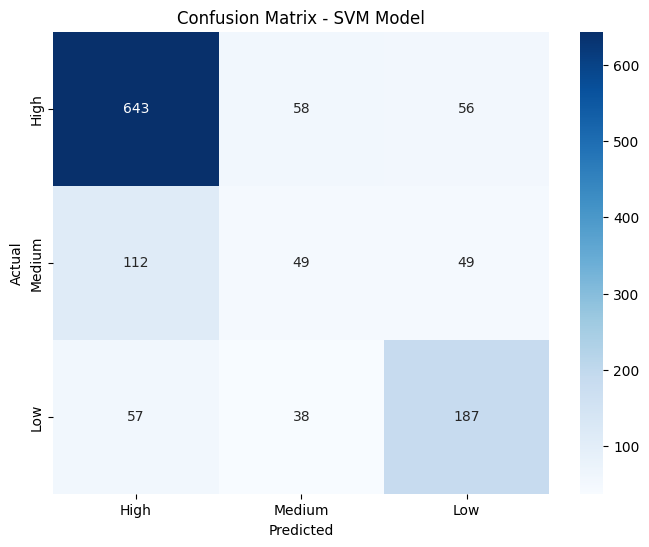

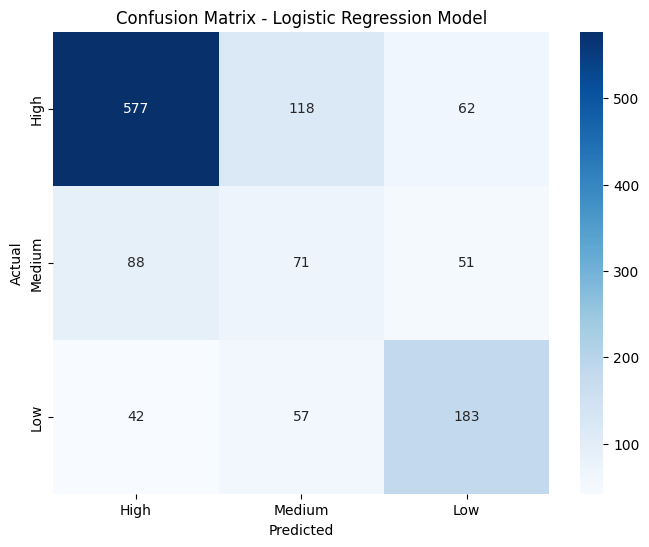

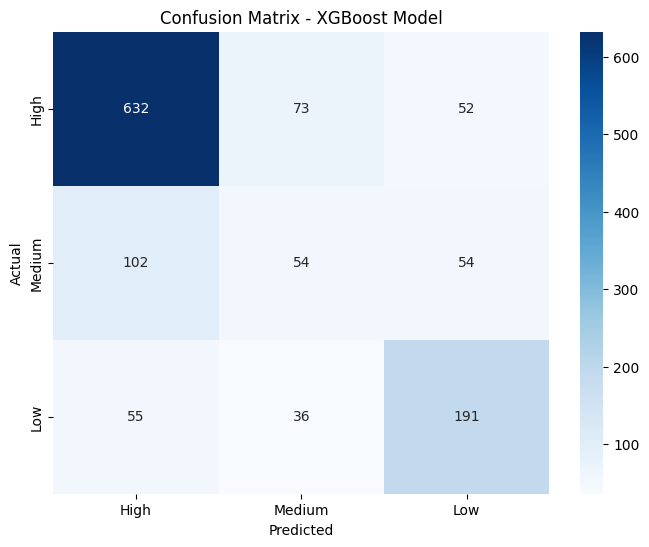

Training SVM...
F1-Score: 0.6903
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       757
           1       0.34      0.23      0.28       210
           2       0.64      0.66      0.65       282

    accuracy                           0.70      1249
   macro avg       0.59      0.58      0.58      1249
weighted avg       0.68      0.70      0.69      1249

Training Logistic Regression...
F1-Score: 0.6731
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       757
           1       0.29      0.34      0.31       210
           2       0.62      0.65      0.63       282

    accuracy                           0.67      1249
   macro avg       0.57      0.58      0.58      1249
weighted avg       0.68      0.67      0.67      1249

Training XGBoost...
F1-Score: 0.6932
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       757
          

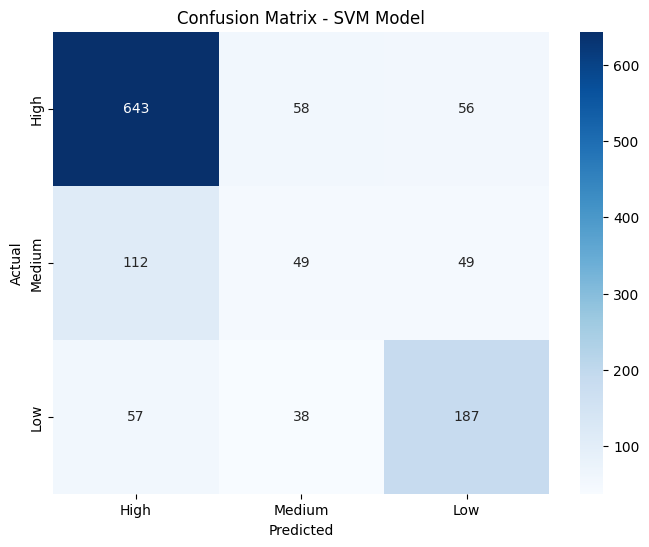

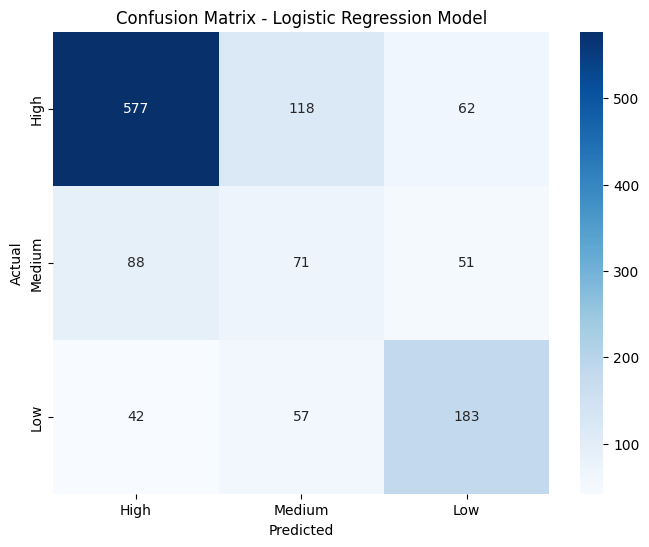

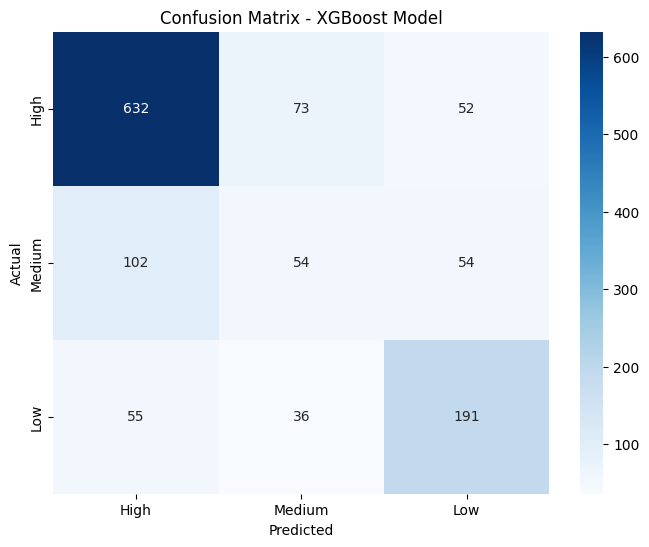

Training SVM...
F1-Score: 0.6759
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       757
           1       0.27      0.41      0.33       210
           2       0.61      0.70      0.65       282

    accuracy                           0.65      1249
   macro avg       0.59      0.61      0.59      1249
weighted avg       0.72      0.65      0.68      1249

Training Logistic Regression...
F1-Score: 0.6764
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       757
           1       0.28      0.40      0.32       210
           2       0.61      0.70      0.65       282

    accuracy                           0.66      1249
   macro avg       0.58      0.60      0.59      1249
weighted avg       0.71      0.66      0.68      1249

Training XGBoost...
F1-Score: 0.6985
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       757
          

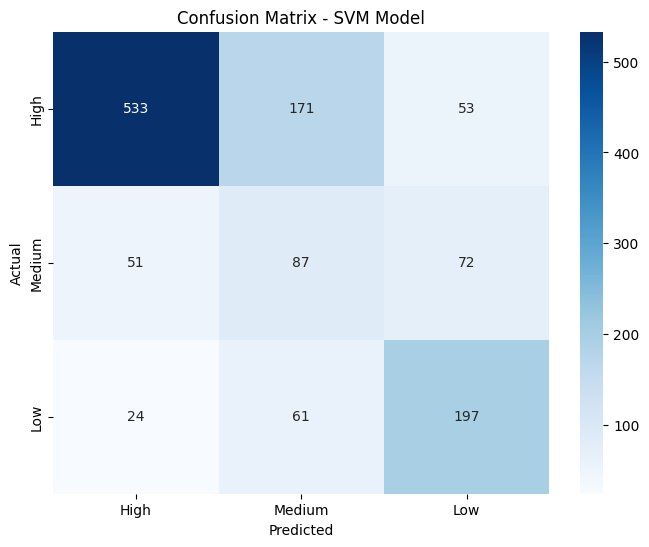

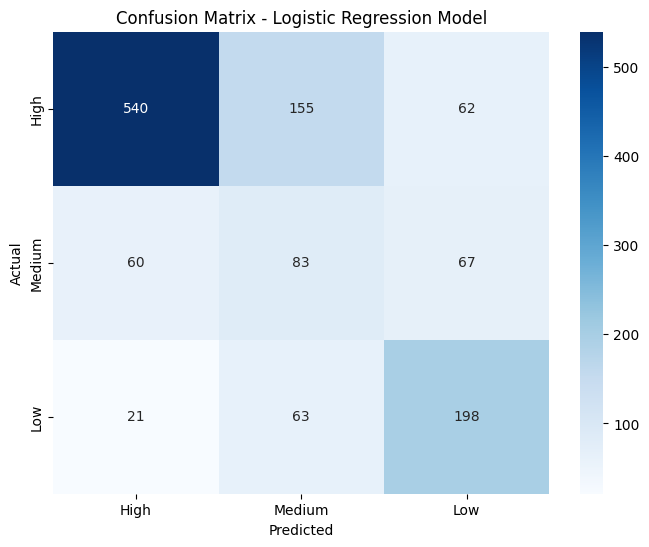

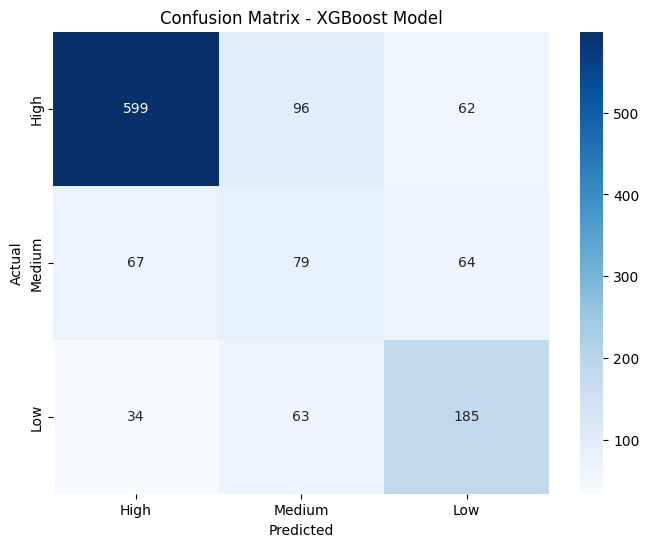

Training SVM...
F1-Score: 0.6759
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       757
           1       0.27      0.41      0.33       210
           2       0.61      0.70      0.65       282

    accuracy                           0.65      1249
   macro avg       0.59      0.61      0.59      1249
weighted avg       0.72      0.65      0.68      1249

Training Logistic Regression...
F1-Score: 0.6764
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       757
           1       0.28      0.40      0.32       210
           2       0.61      0.70      0.65       282

    accuracy                           0.66      1249
   macro avg       0.58      0.60      0.59      1249
weighted avg       0.71      0.66      0.68      1249

Training XGBoost...
F1-Score: 0.6985
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       757
          

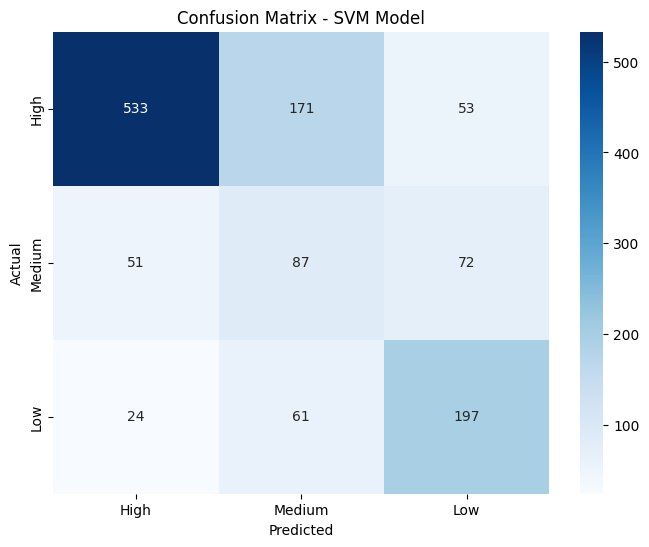

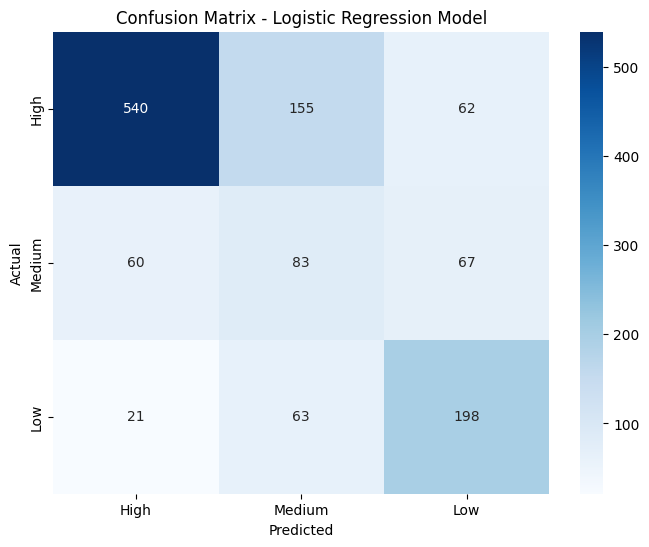

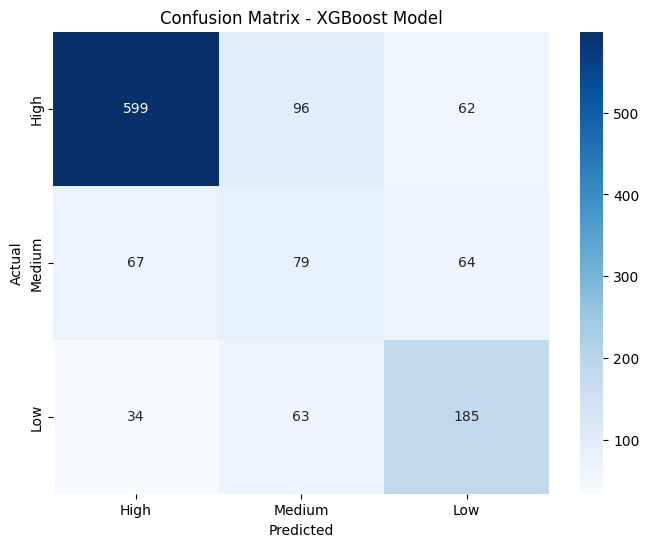

In [19]:
model_eval_tfidf = ModelEvaluation(combined_tfidf, data['rating_category_encoded'])
model_eval_tfidf.evaluate_and_plot()

model_eval_word2vec = ModelEvaluation(combined_word2vec, data['rating_category_encoded'])
model_eval_word2vec.evaluate_and_plot()
